In [6]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [8]:
df = pd.read_csv('fetal_health.csv', 
               usecols=["accelerations",
                        "fetal_movement",
                        "uterine_contractions",
                        "light_decelerations",
                        "severe_decelerations",
                        "prolongued_decelerations",
                        "abnormal_short_term_variability",
                        "mean_value_of_short_term_variability",
                        "percentage_of_time_with_abnormal_long_term_variability",
                        "mean_value_of_long_term_variability",
                        "fetal_health"])
#I did leave behind some columns that seemed like overcrowding at this point. I will deal with them in the next step of this model.
print(df.shape)
df.head()

(2126, 11)


,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,2.0
1,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,1.0
2,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,1.0
3,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,1.0
4,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,1.0


In [9]:
df.loc[df['fetal_health'] == 1, 'fetal_health'] = 0
df.loc[df['fetal_health'] == 2, 'fetal_health'] = 1
df.loc[df['fetal_health'] == 3, 'fetal_health'] = 2
df['fetal_health'].unique()

array([1., 0., 2.])

C:\Users\PC\Desktop\TFProj\tfvenv\Lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


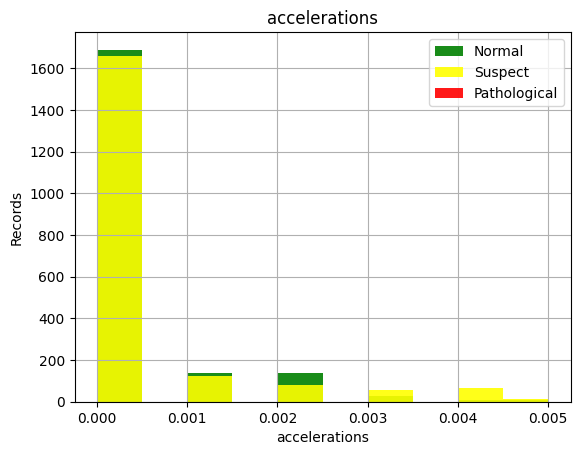

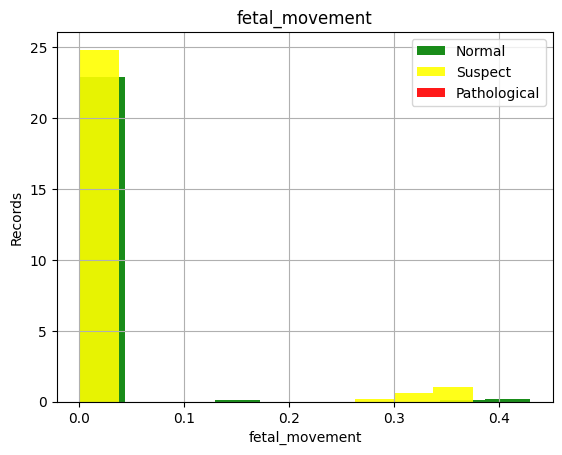

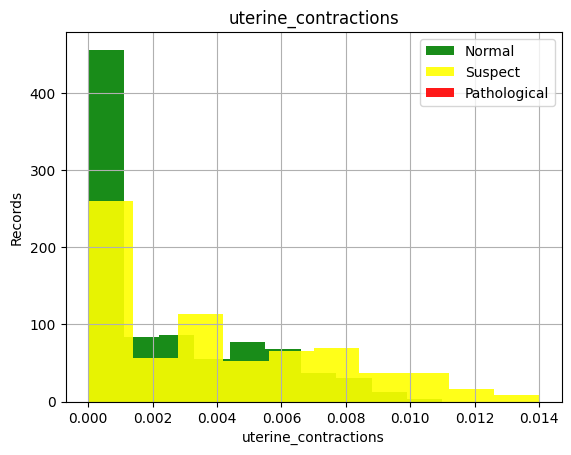

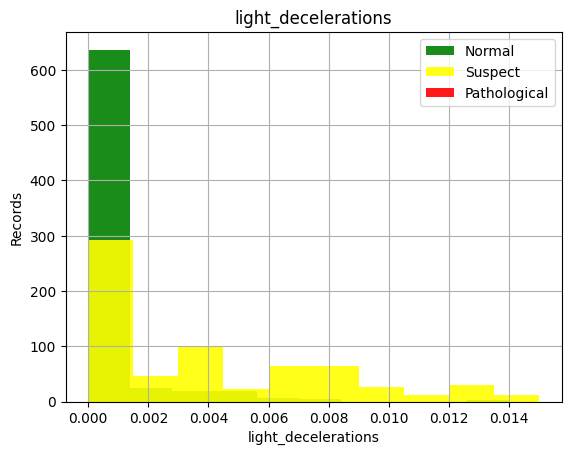

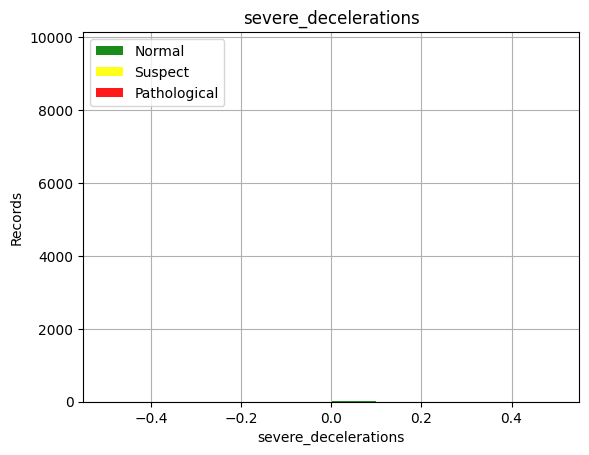

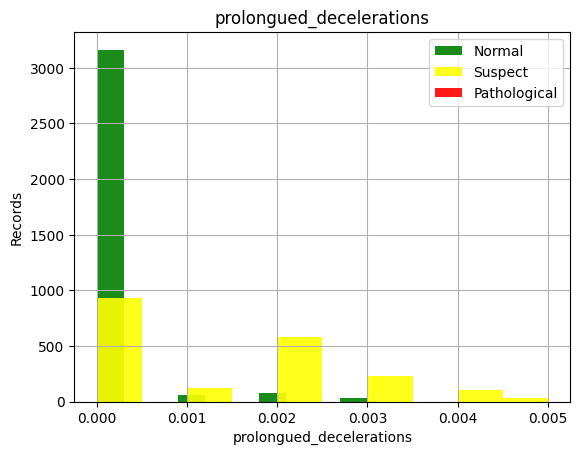

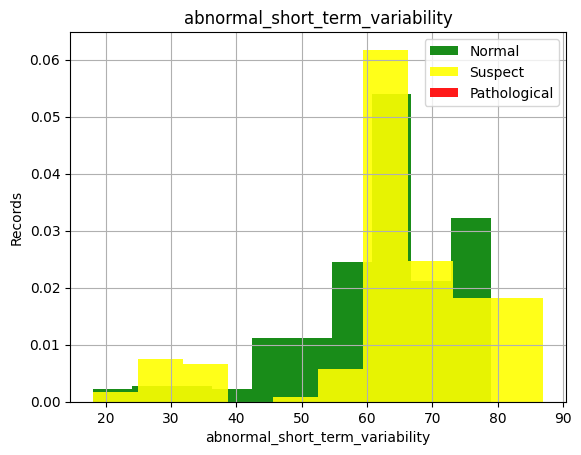

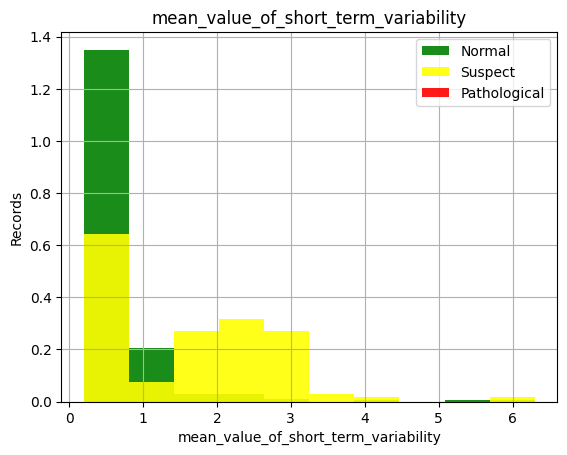

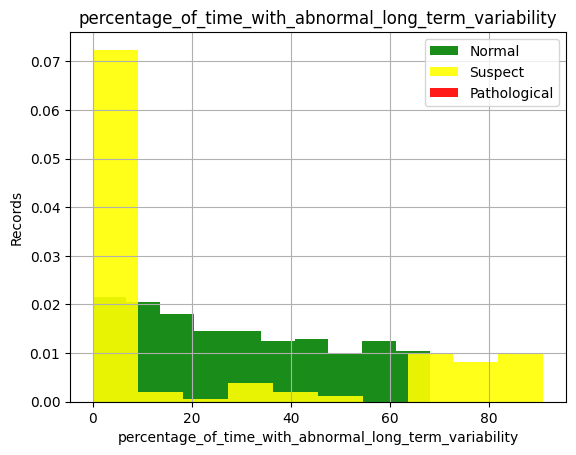

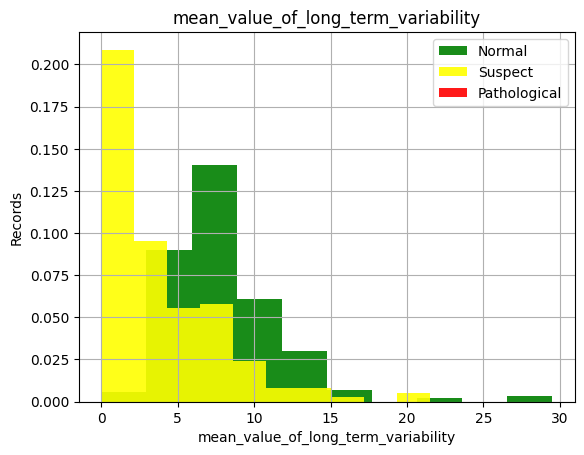

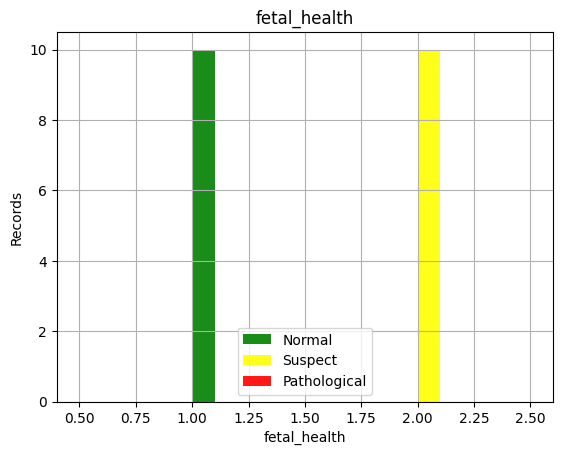

In [11]:
for label in df.columns:
  plt.hist(df[df['fetal_health']==1][label], color = "green", label = "Normal", alpha = 0.9, density = True)
  plt.hist(df[df['fetal_health']==2][label], color = "yellow", label = "Suspect", alpha = 0.9, density = True)
  plt.hist(df[df['fetal_health']==3][label], color = "red", label = "Pathological", alpha = 0.9, density = True)
  plt.xlabel(label)
  plt.ylabel("Records")
  plt.title(label)
  plt.legend()
  plt.grid()
  plt.show()

TRAIN, VALIDATION AND TEST DATASETS

In [12]:
print(len(df[df['fetal_health']==0]))
print(len(df[df['fetal_health']==1]))
print(len(df[df['fetal_health']==2]))

1655
295
176


Down-Sampling:

In [13]:
indexes_to_remove = df[df['fetal_health'] == 0].sample(n=1350, random_state=42).index
df = df.drop(index=indexes_to_remove).reset_index(drop=True)

In [14]:
print(len(df[df['fetal_health']==0]))
print(len(df[df['fetal_health']==1]))
print(len(df[df['fetal_health']==2]))

305
295
176


In [25]:
train = df.iloc[:int(0.6 * len(df))]
valid = df.iloc[int(0.6 * len(df)):int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]
print(train.shape, valid.shape, test.shape)

(465, 11) (155, 11) (156, 11)


In [26]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
print((train.iloc[:, -1] == 1).sum())
print((valid.iloc[:, -1] == 1).sum())
print((test.iloc[:, -1] == 1).sum())

170
59
66


In [28]:
def scale_datasets(dataframe, oversample = False):
  X = dataframe[dataframe.columns[:-1]].values
  Y = dataframe[dataframe.columns[-1]].values.ravel()  # ensures Y is 1D

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, Y = ros.fit_resample(X, Y)

  data = np.hstack((X, np.reshape(Y, (-1, 1))))

  return data, X, Y

In [29]:
train, X_train, Y_train = scale_datasets(train, oversample = True)
valid, X_valid, Y_valid = scale_datasets(valid, oversample = False)
test, X_test, Y_test = scale_datasets(test, oversample = False)

In [30]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3))
  ax1.plot(history.history['loss'], label = "loss")
  ax1.plot(history.history['val_loss'], label = "val_loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Binary Crossentropy")
  ax1.grid(True)
  ax1.legend()

  ax2.plot(history.history['accuracy'], label = "accuracy")
  ax2.plot(history.history['val_accuracy'], label = "val_accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.grid(True)
  ax2.legend()

  plt.show()

In [31]:
def train_model(X_train, Y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation = "relu", input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob), #this is so that it prevents overfitting
      tf.keras.layers.Dense(num_nodes, activation = "relu"),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(3, activation = "linear")])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
  history = nn_model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, Y_valid), verbose=0)
  return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


C:\Users\PC\Desktop\TFProj\tfvenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


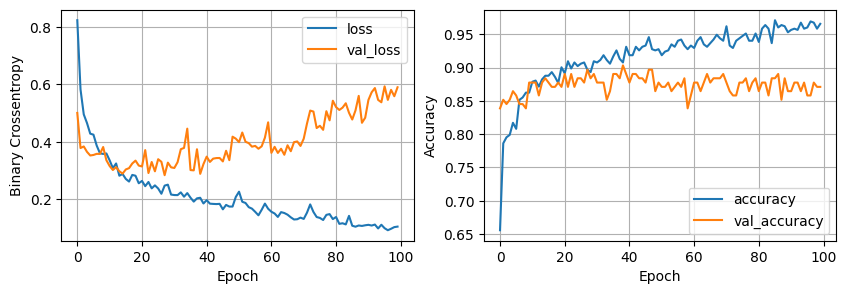

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8784 - loss: 0.6060 
16 nodes, dropout 0, lr 0.01, batch size 64


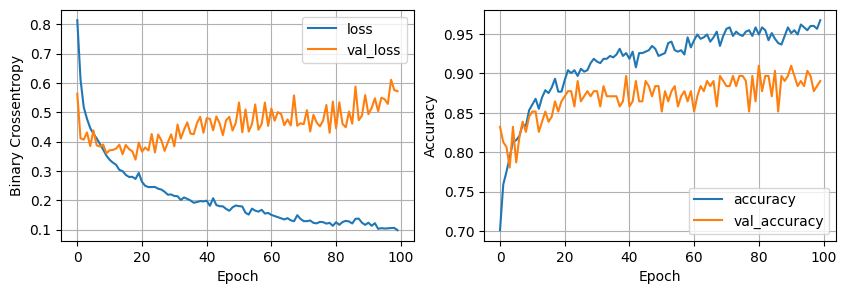

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.5870 
16 nodes, dropout 0, lr 0.01, batch size 128


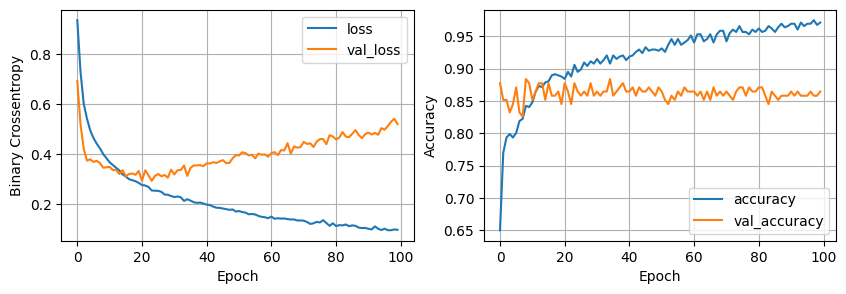

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8824 - loss: 0.4264 
16 nodes, dropout 0, lr 0.005, batch size 32


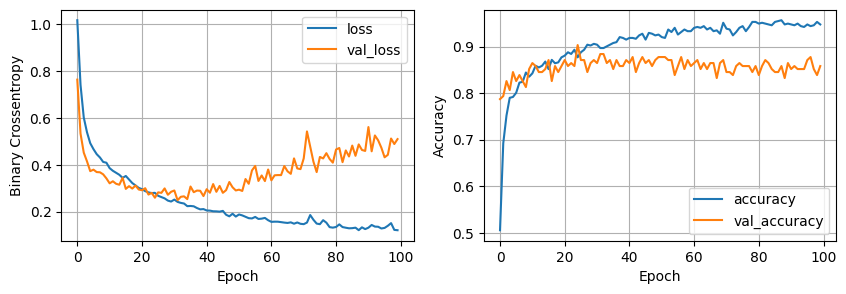

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.4346 
16 nodes, dropout 0, lr 0.005, batch size 64


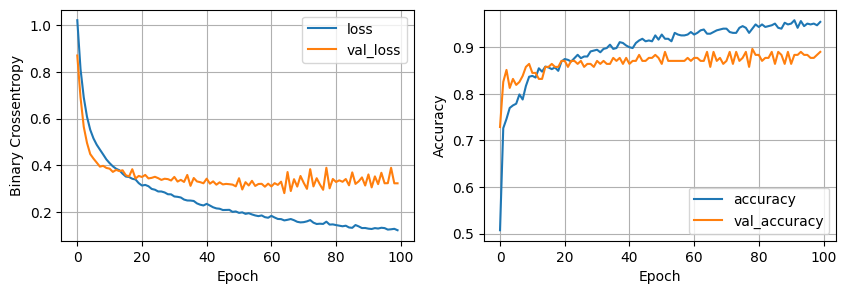

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9079 - loss: 0.3011 
16 nodes, dropout 0, lr 0.005, batch size 128


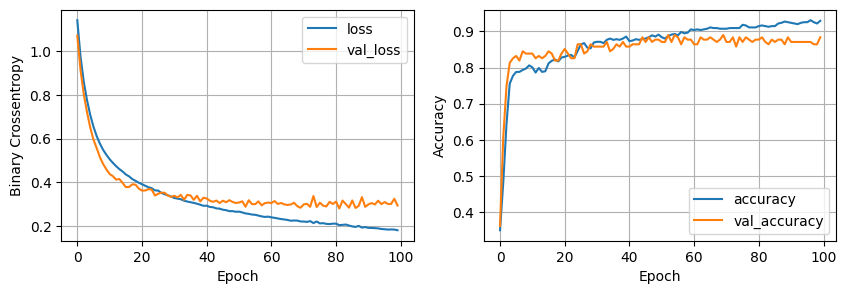

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8949 - loss: 0.2654 
16 nodes, dropout 0, lr 0.001, batch size 32


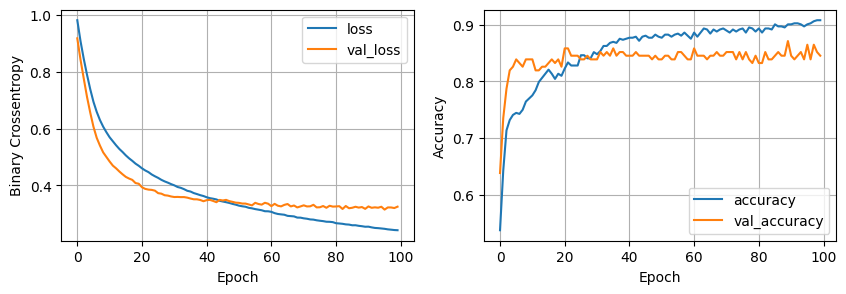

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8581 - loss: 0.3198 
16 nodes, dropout 0, lr 0.001, batch size 64


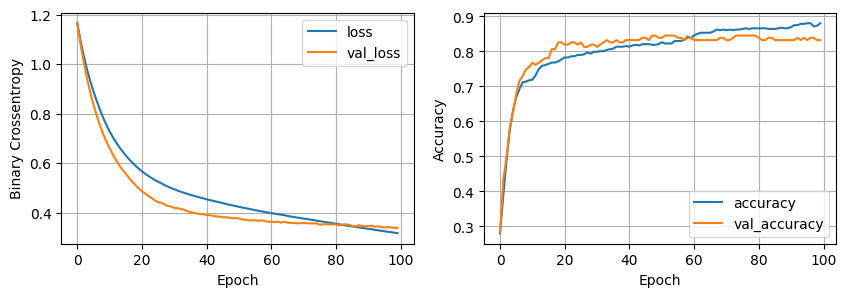

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3131 
16 nodes, dropout 0, lr 0.001, batch size 128


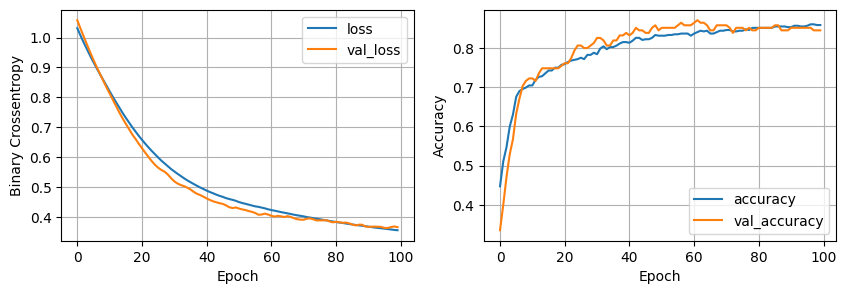

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8620 - loss: 0.3473 
16 nodes, dropout 0.2, lr 0.01, batch size 32


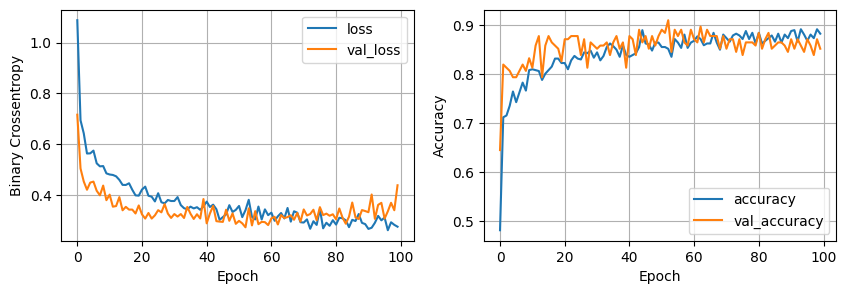

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8603 - loss: 0.4153 
16 nodes, dropout 0.2, lr 0.01, batch size 64


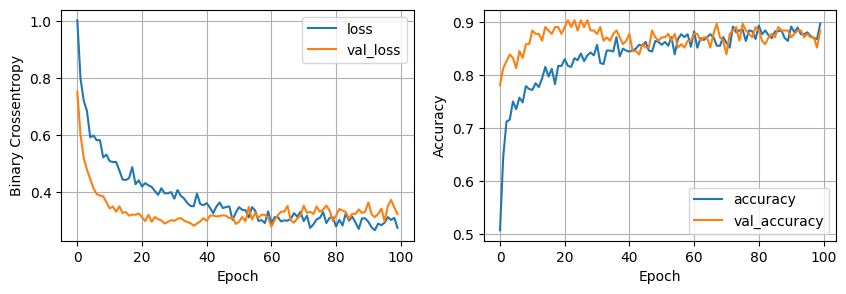

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8918 - loss: 0.3009 
16 nodes, dropout 0.2, lr 0.01, batch size 128


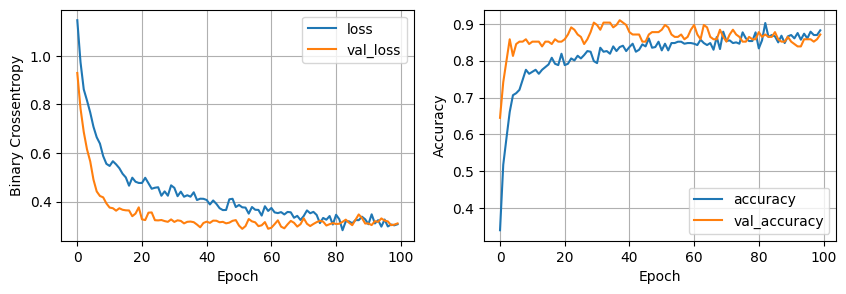

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8862 - loss: 0.2657 
16 nodes, dropout 0.2, lr 0.005, batch size 32


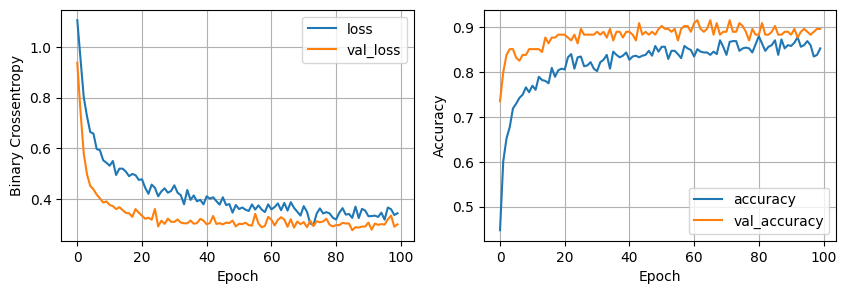

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9087 - loss: 0.3067 
16 nodes, dropout 0.2, lr 0.005, batch size 64


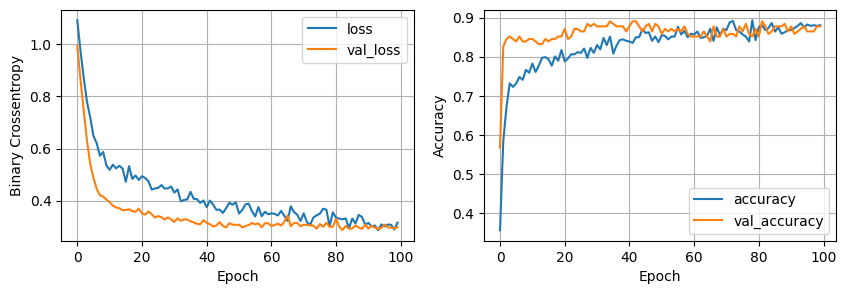

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.2867 
16 nodes, dropout 0.2, lr 0.005, batch size 128


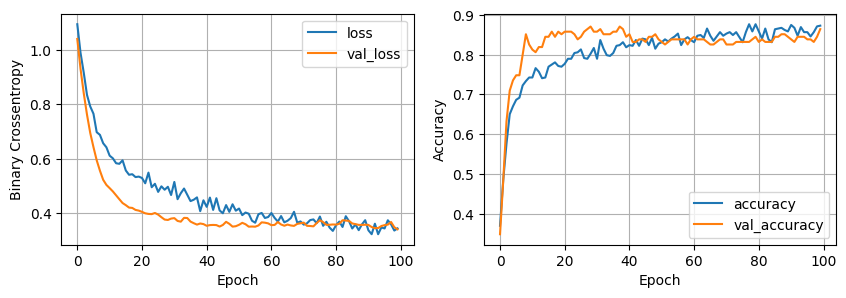

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8732 - loss: 0.3294 
16 nodes, dropout 0.2, lr 0.001, batch size 32


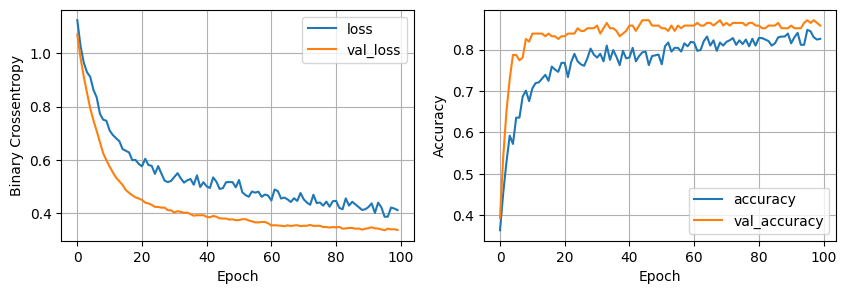

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.3269 
16 nodes, dropout 0.2, lr 0.001, batch size 64


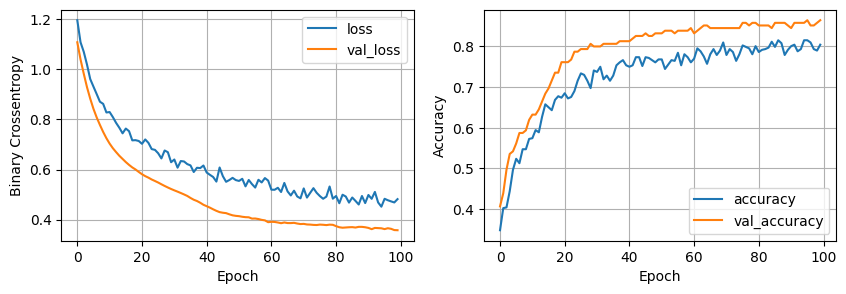

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8958 - loss: 0.3389 
16 nodes, dropout 0.2, lr 0.001, batch size 128


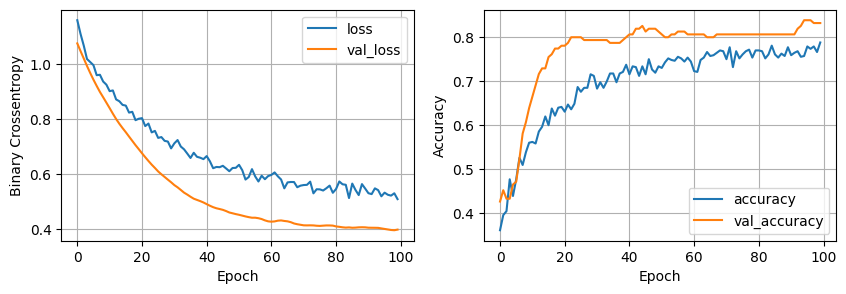

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.3697 
32 nodes, dropout 0, lr 0.01, batch size 32


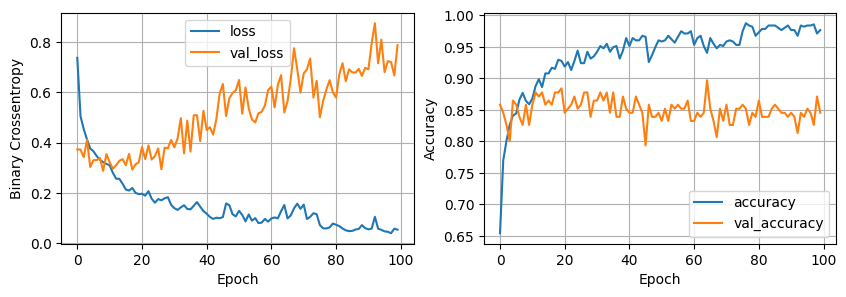

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8412 - loss: 0.8796 
32 nodes, dropout 0, lr 0.01, batch size 64


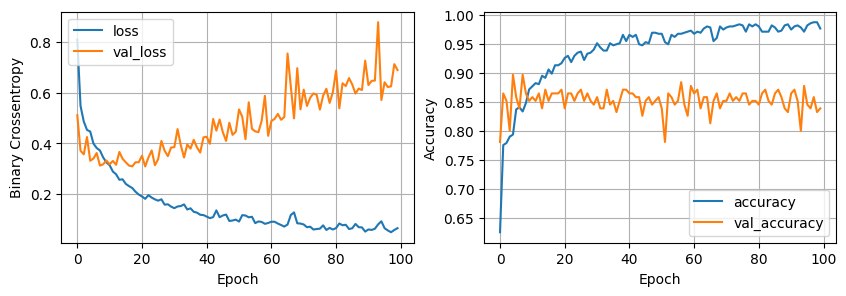

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.6604 
32 nodes, dropout 0, lr 0.01, batch size 128


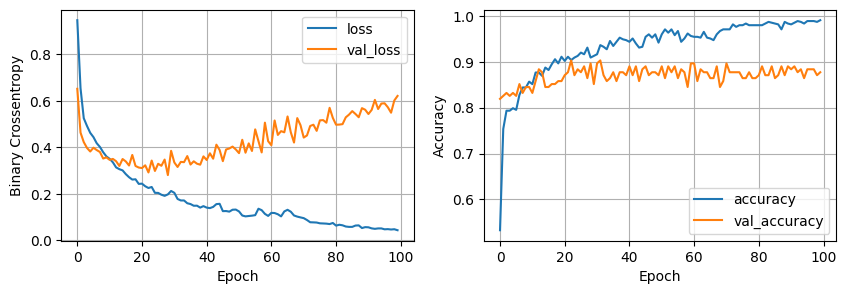

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8801 - loss: 0.5299 
32 nodes, dropout 0, lr 0.005, batch size 32


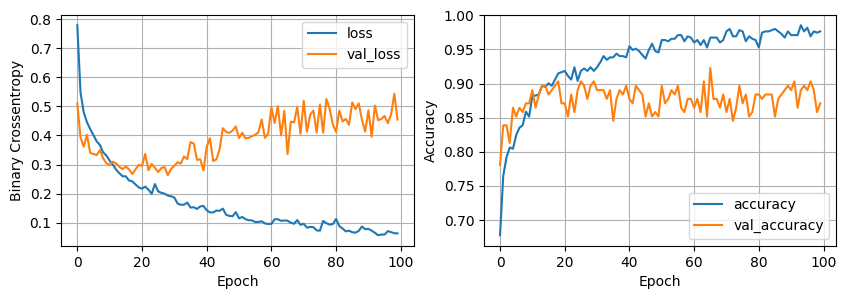

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8810 - loss: 0.4464 
32 nodes, dropout 0, lr 0.005, batch size 64


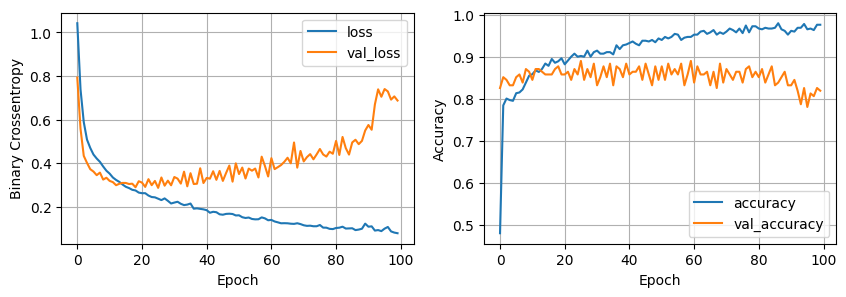

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8382 - loss: 0.6080 
32 nodes, dropout 0, lr 0.005, batch size 128


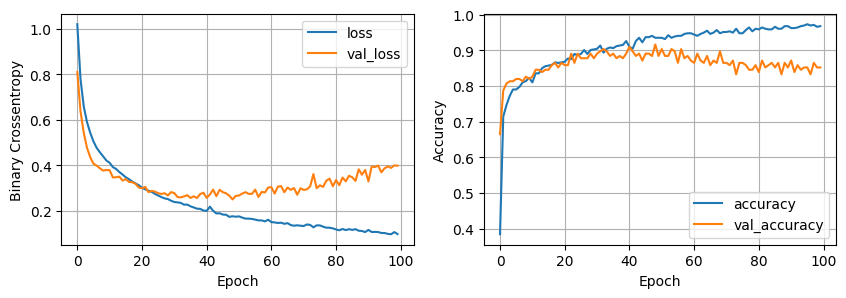

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.3158 
32 nodes, dropout 0, lr 0.001, batch size 32


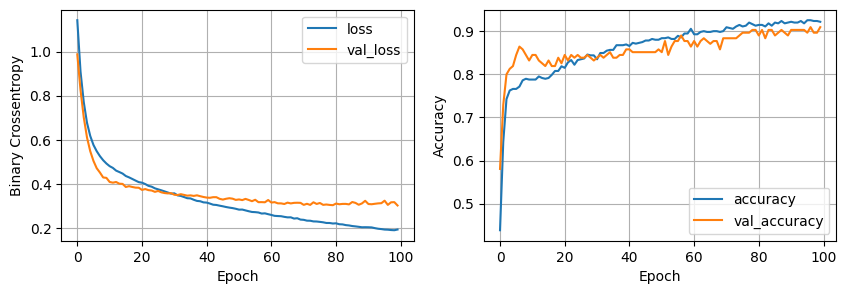

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9039 - loss: 0.3034 
32 nodes, dropout 0, lr 0.001, batch size 64


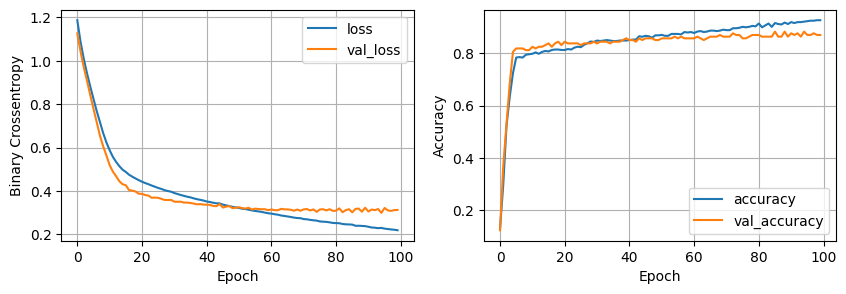

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8728 - loss: 0.3028 
32 nodes, dropout 0, lr 0.001, batch size 128


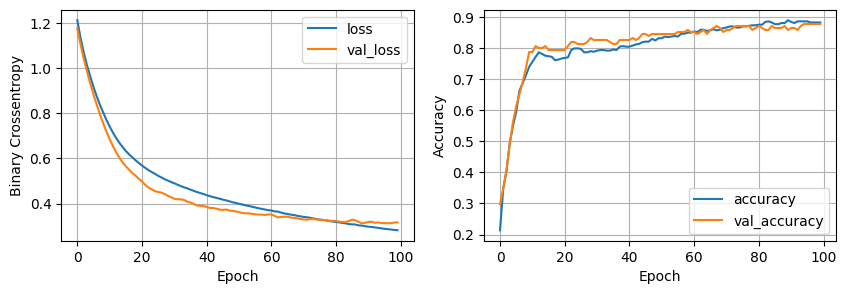

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8867 - loss: 0.2902 
32 nodes, dropout 0.2, lr 0.01, batch size 32


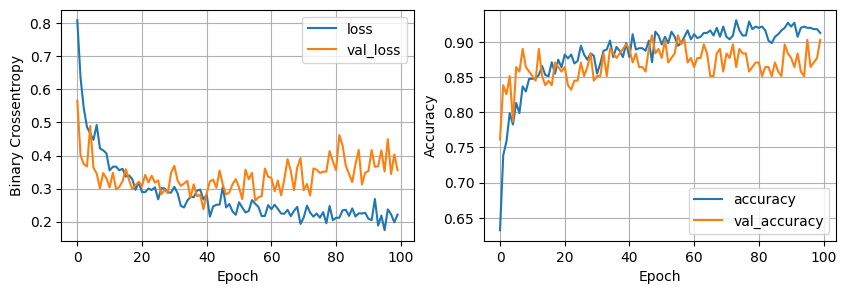

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9178 - loss: 0.2793 
32 nodes, dropout 0.2, lr 0.01, batch size 64


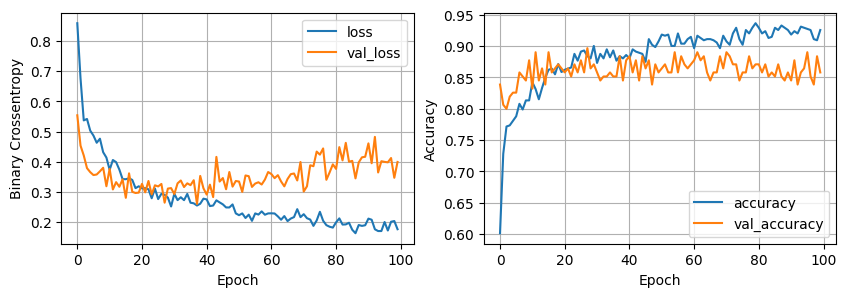

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.3832 
32 nodes, dropout 0.2, lr 0.01, batch size 128


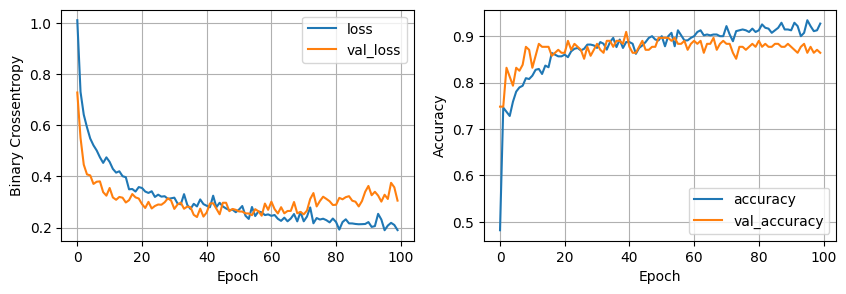

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8581 - loss: 0.2952 
32 nodes, dropout 0.2, lr 0.005, batch size 32


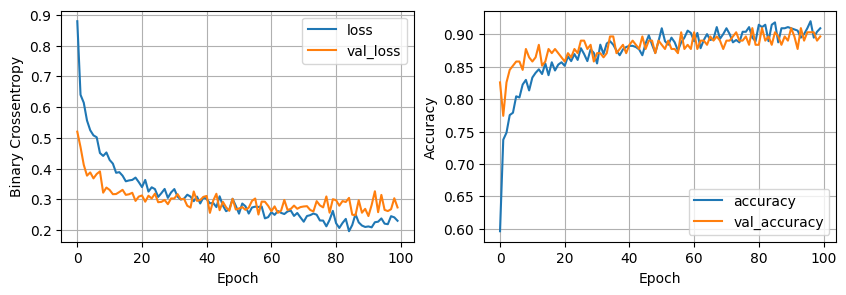

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9066 - loss: 0.2618 
32 nodes, dropout 0.2, lr 0.005, batch size 64


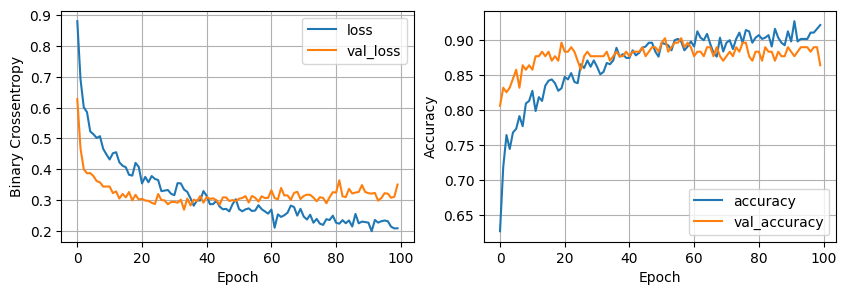

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8793 - loss: 0.3161 
32 nodes, dropout 0.2, lr 0.005, batch size 128


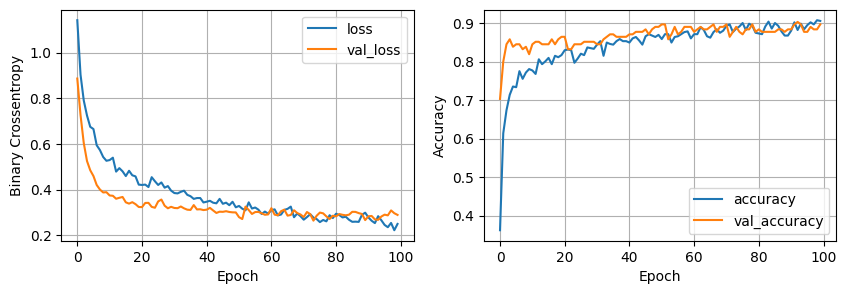

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9022 - loss: 0.2844 
32 nodes, dropout 0.2, lr 0.001, batch size 32


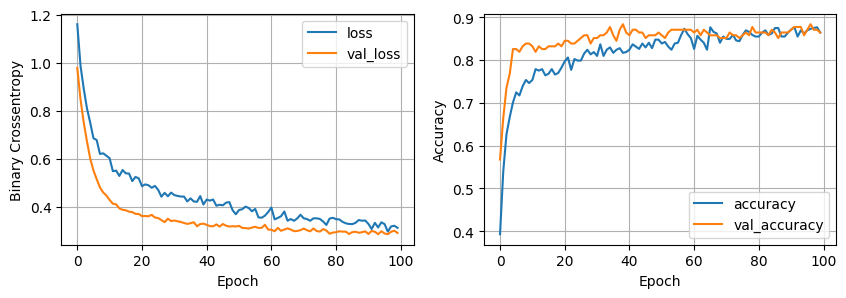

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8732 - loss: 0.2744 
32 nodes, dropout 0.2, lr 0.001, batch size 64


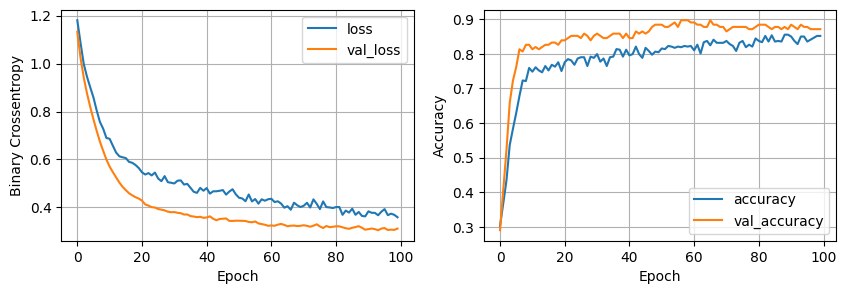

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8728 - loss: 0.3047 
32 nodes, dropout 0.2, lr 0.001, batch size 128


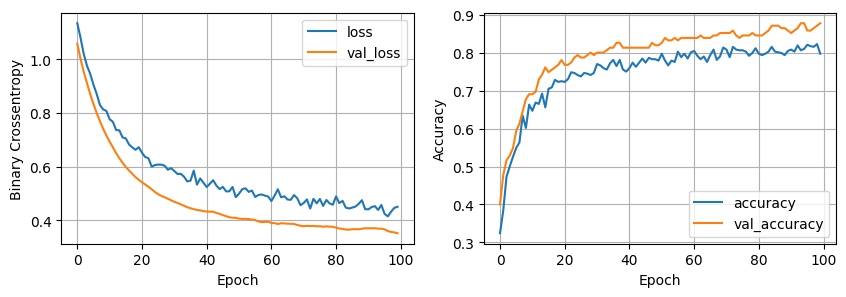

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.3377 
64 nodes, dropout 0, lr 0.01, batch size 32


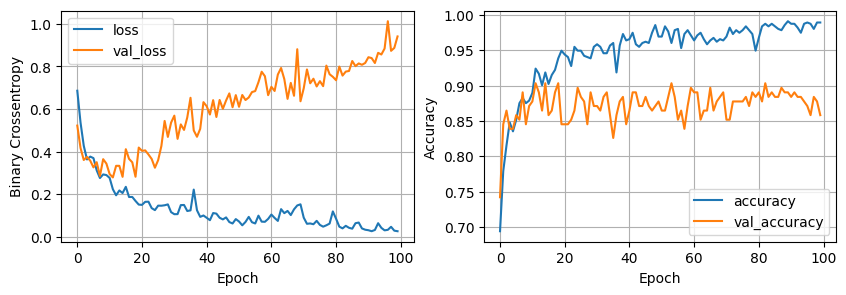

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8650 - loss: 0.8299 
64 nodes, dropout 0, lr 0.01, batch size 64


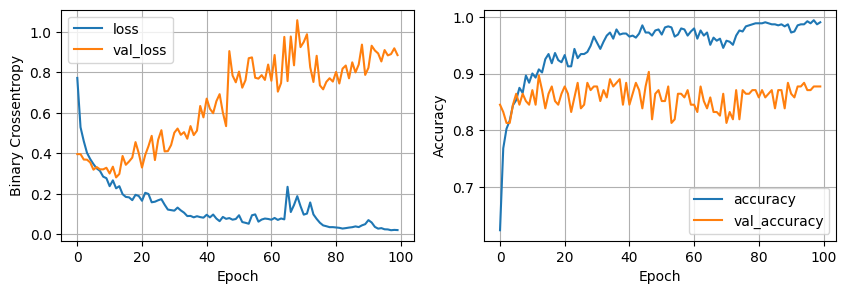

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8810 - loss: 0.8993 
64 nodes, dropout 0, lr 0.01, batch size 128


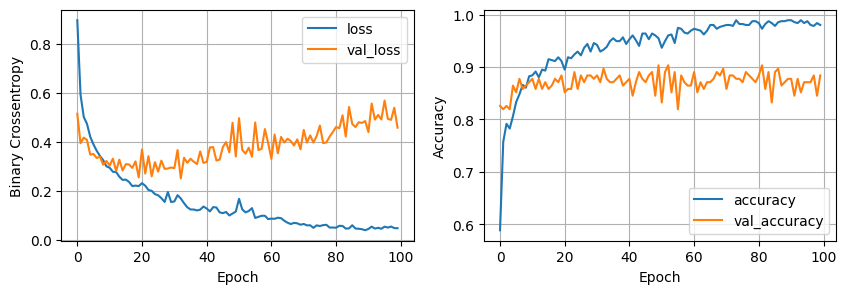

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8931 - loss: 0.4283 
64 nodes, dropout 0, lr 0.005, batch size 32


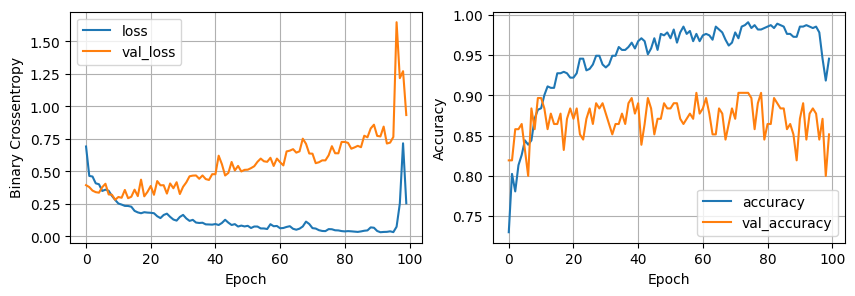

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8581 - loss: 0.9828 
64 nodes, dropout 0, lr 0.005, batch size 64


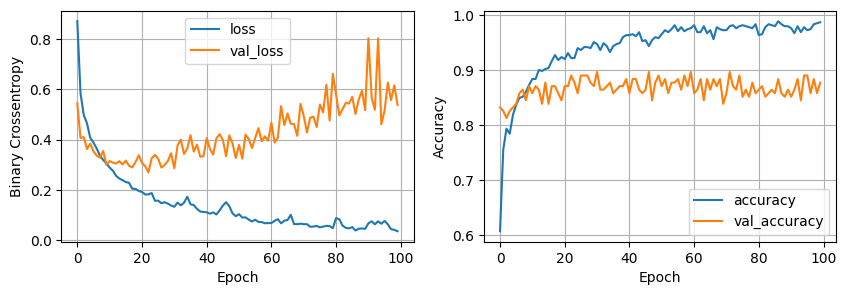

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8784 - loss: 0.4582 
64 nodes, dropout 0, lr 0.005, batch size 128


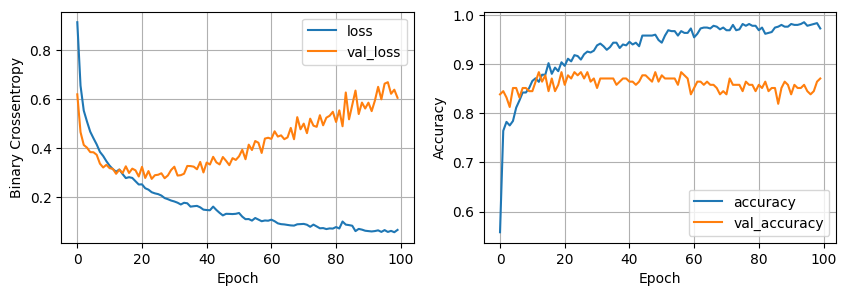

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.5394 
64 nodes, dropout 0, lr 0.001, batch size 32


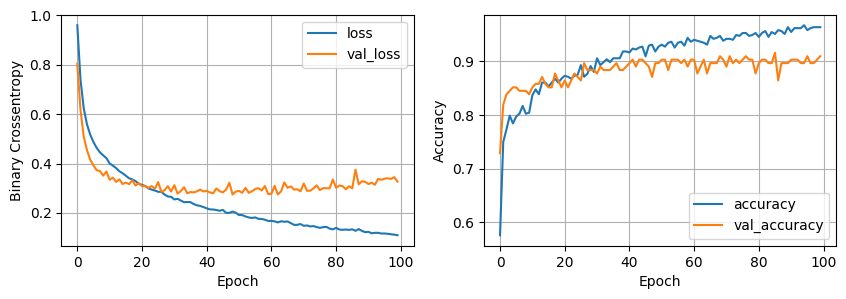

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9039 - loss: 0.2979 
64 nodes, dropout 0, lr 0.001, batch size 64


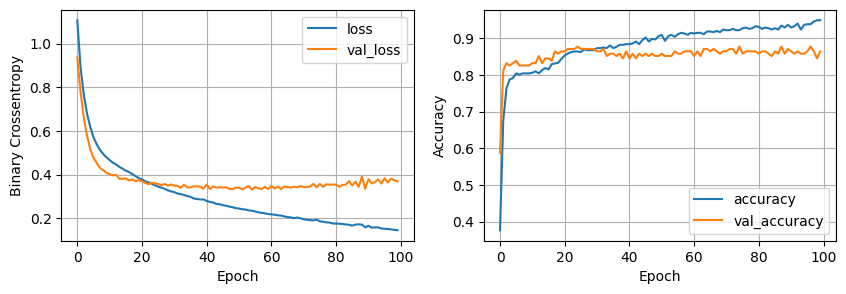

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8732 - loss: 0.3392 
64 nodes, dropout 0, lr 0.001, batch size 128


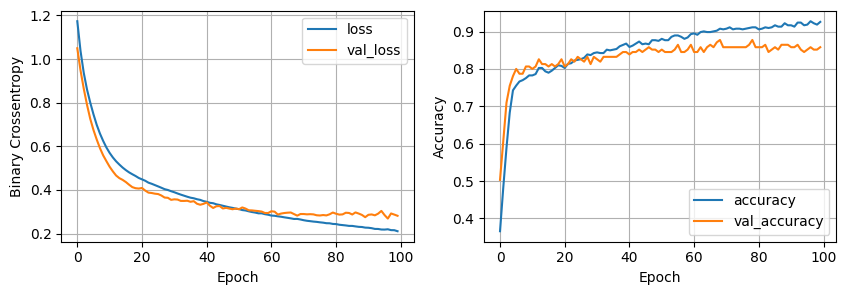

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.2480 
64 nodes, dropout 0.2, lr 0.01, batch size 32


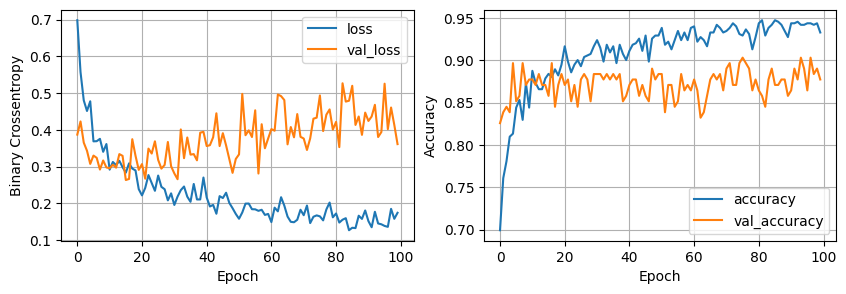

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.3447 
64 nodes, dropout 0.2, lr 0.01, batch size 64


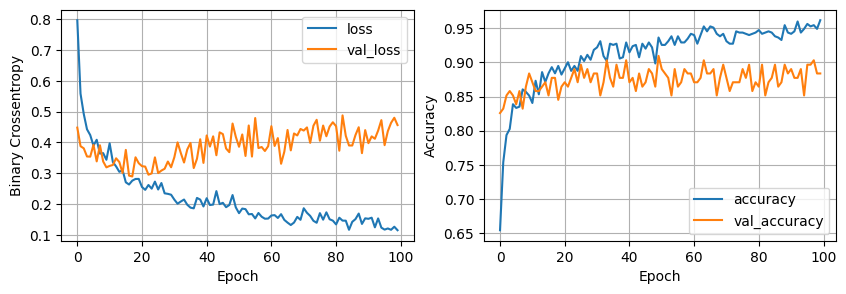

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8914 - loss: 0.4411 
64 nodes, dropout 0.2, lr 0.01, batch size 128


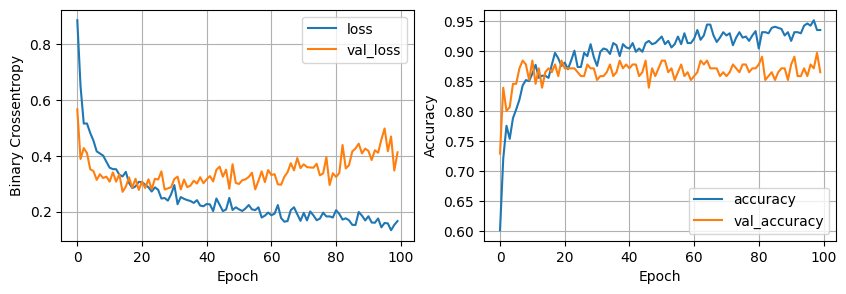

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8732 - loss: 0.3571 
64 nodes, dropout 0.2, lr 0.005, batch size 32


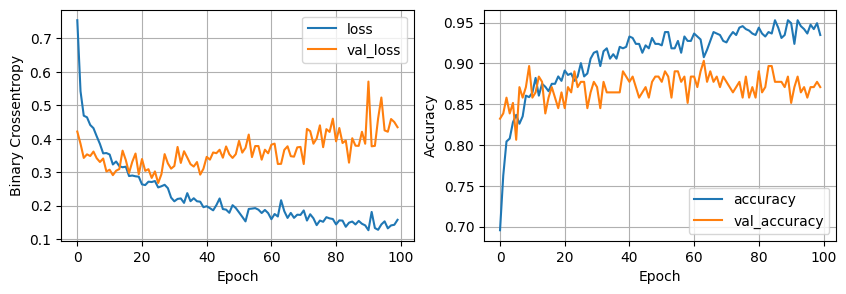

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8767 - loss: 0.4176 
64 nodes, dropout 0.2, lr 0.005, batch size 64


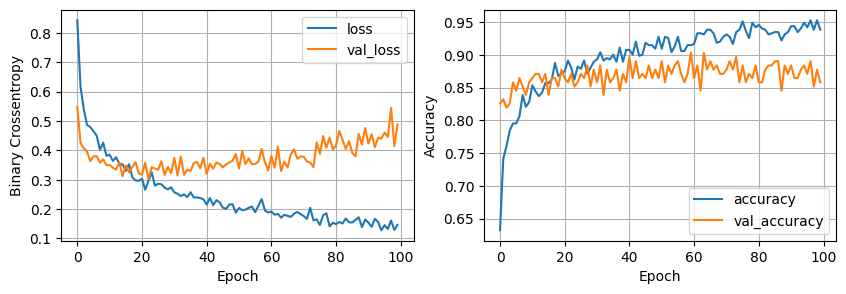

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8707 - loss: 0.4231 
64 nodes, dropout 0.2, lr 0.005, batch size 128


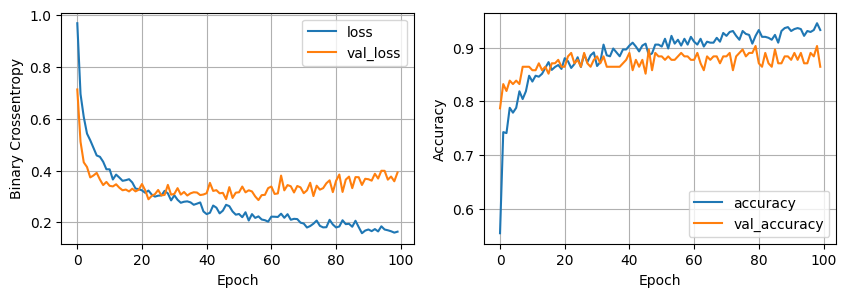

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.3292 
64 nodes, dropout 0.2, lr 0.001, batch size 32


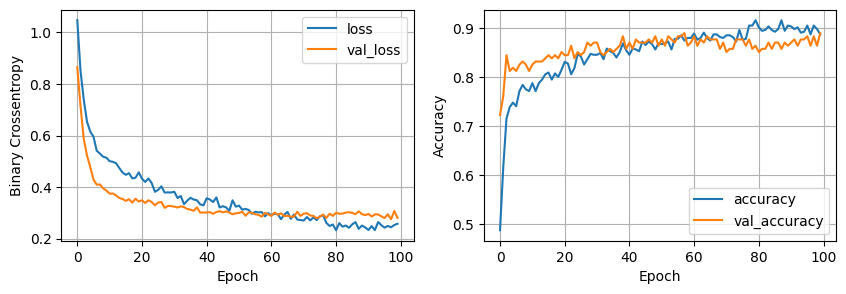

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.2743 
64 nodes, dropout 0.2, lr 0.001, batch size 64


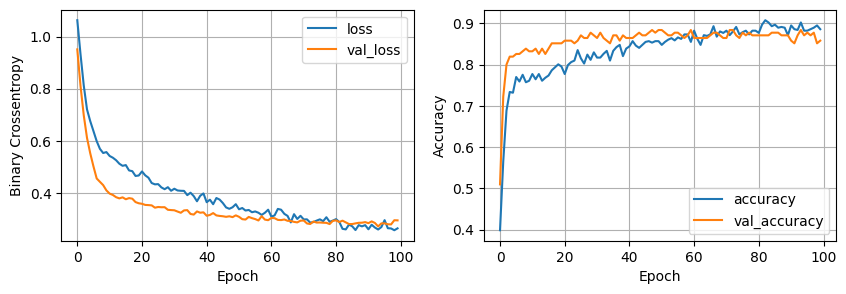

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8733 - loss: 0.2946 
64 nodes, dropout 0.2, lr 0.001, batch size 128


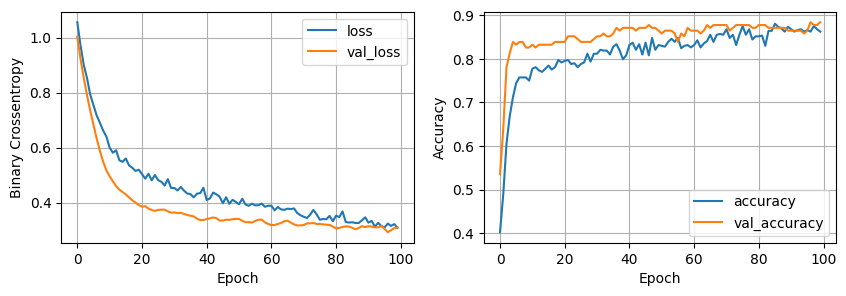

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8875 - loss: 0.2990 


In [32]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, Y_train , num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, Y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [33]:
print(least_val_loss)

0.2733922600746155


In [34]:
Y_pred = least_loss_model.predict(X_test)
Y_pred = (Y_pred == Y_pred.max(axis=1, keepdims=True)).astype(int)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = Y_test.astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [35]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        61
           1       0.84      0.89      0.87        66
           2       0.81      0.90      0.85        29

    accuracy                           0.87       156
   macro avg       0.86      0.87      0.86       156
weighted avg       0.87      0.87      0.87       156



Used down-sampling to make sure the model learns categories 1 and 2, it did.